# Classifying High-Energy Seismic Bumps using Machine Learning

### Step 1: Import and Clean the Data

#### 1.1 Import the .arff file and convert it into a dataframe

In [120]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


In [121]:
data = arff.loadarff('seismic-bumps.arff')
df = pd.DataFrame(data[0])
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,b'a',b'a',b'N',15180.0,48.0,-72.0,-72.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
1,b'a',b'a',b'N',14720.0,33.0,-70.0,-79.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,b'0'
2,b'a',b'a',b'N',8050.0,30.0,-81.0,-78.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'
3,b'a',b'a',b'N',28820.0,171.0,-23.0,40.0,b'a',1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,b'0'
4,b'a',b'a',b'N',12640.0,57.0,-63.0,-52.0,b'a',0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,b'0'


In [122]:
# fix broken string columns by decoding them to utf-8 
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.str.decode("utf-8"))

In [123]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [124]:
df["class"].value_counts()

0    2414
1     170
Name: class, dtype: int64

In [125]:
df["class"] = df["class"].astype(np.int64)

In [126]:
# Convert to CSV
# df.to_csv('seismic-bumps.csv', encoding='utf-8', index = False)

#### 1.2 Clean the data, making transformations as necessary

In [127]:
# Convert seismic intensity levels from categorical to numerical
# Note: we assign values in an increasing order so that it can represent rising intensity levels
def map_seismic_intensity(i):
    if i == 'a':
        return 0
    elif i == 'b':
        return 1
    elif i == 'c':
        return 2
    elif i == 'd':
        return 3
    
    
# Map the associated columns
df["seismic"] = df["seismic"].apply(lambda x: map_seismic_intensity(x))
df["seismoacoustic"] = df["seismoacoustic"].apply(lambda x: map_seismic_intensity(x))
df["ghazard"] = df["ghazard"].apply(lambda x: map_seismic_intensity(x))

# Convert the shift column to binary
df["shift"] = df["shift"].apply(lambda x: 1 if x == 'W' else 0)

df["class"] = np.where(df['class'] == 0, -1, 1)

# Fill NAs
df = df.fillna(0)

In [128]:
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,0,0,0,15180.0,48.0,-72.0,-72.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
1,0,0,0,14720.0,33.0,-70.0,-79.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,-1
2,0,0,0,8050.0,30.0,-81.0,-78.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3,0,0,0,28820.0,171.0,-23.0,40.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,-1
4,0,0,0,12640.0,57.0,-63.0,-52.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1


In [129]:
df["class"].value_counts()

-1    2414
 1     170
Name: class, dtype: int64

## Step 2: Exploratory Data Analysis

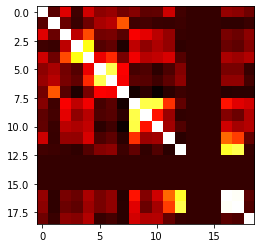

In [130]:
# Multivariate correlation analysis

plt.imshow(df.corr().fillna(0), cmap='hot', interpolation='nearest')
plt.show()


In [131]:
# A look at class distributions
df["class"].value_counts()

-1    2414
 1     170
Name: class, dtype: int64

As evident, there aren't many rows for the positive label. This data is highly imbalanced and can skew the results of our model.

## Step 3: Instantiating and training the Model

In [132]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.gaussian_process.kernels import RBF

X = df.iloc[:, :17]
y = df.iloc[:, 18]

# Applying the SMOTE(Synthetic Minority Oversampling Technique) algorithm for oversampling
smote = SMOTE()

# # fit predictor and target variable
X_smote, y_smote = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_smote))

X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.3, random_state = 42)

Original dataset shape Counter({-1: 2414, 1: 170})
Resample dataset shape Counter({-1: 2414, 1: 2414})


In [133]:
# from scipy.spatial.distance import pdist, squareform
# import scipy
# from sklearn.metrics.pairwise import rbf_kernel

In [182]:
class SupportVectorMachine:
    def __init__(self, X, y, max_iterations = 1000, lr = 1e-7, lmbda = 0.1, tolerance = 1e-5, sigma = 0.5, use_kernel = False):
        self.X = np.array(X, dtype=np.float64)
        self.y = np.array(y, dtype=np.float64)
        self.max_iterations = max_iterations
        self.lr = lr
        self.lmbda = lmbda
        self.tolerance = tolerance
        self.sigma = sigma
        self.use_kernel = use_kernel
    
    
    def apply_kernel(self, X):
        gamma = -1 / (2 * self.sigma ** 2)
        kernel_function = lambda X, y: np.exp(gamma * np.square(X[:, np.newaxis] - y).sum(axis=2))
        
        return kernel_function(self.X, self.X)
    
    def add_intercept(self):
        self.X = np.column_stack([np.ones([self.X.shape[0], 1]) , self.X])
        
        
    def cost(self, X, y, W):
        n = len(y)
        
        distances = np.dot(X, W)
        distances[distances < 0] = 0
        

        hinge_loss = self.lmbda * np.sum(distances)/n
        
        cost = 1/2*(np.linalg.norm(W)) + hinge_loss
        
        return cost
    
    def calculate_gradient(self, X, y, W):
        distance = 1 - (np.multiply(y, np.dot(X, W)))
        dw = np.zeros(len(W))

        for i, d in enumerate(distance):
            if max(0, d) == 0:
                di = W
            else:
                di = W - self.lmbda*y[i]*X[i]
            dw += di

        dw = dw/len(y)
        return dw

    def gradient_descent(self):
        self.error_sequences = []
        
        last = float('inf')
        
        
        for i in tqdm(range(self.max_iterations)):
            
            self.W = self.W - self.lr * self.calculate_gradient(self.X, self.y, self.W)
            

            cost = self.cost(self.X, self.y, self.W)
            diff = abs(cost - last)
            last = cost
            
            if i % 100 == 0:
                print("Epoch: {}    Cost: {}".format(i, cost))
            
            self.error_sequences.append(cost)
            
            
            if diff < self.tolerance:
                print("Model Stopped")
                break
            
    
    def predict(self, X, test = False):
        
        if test:
            X = np.column_stack([np.ones([X.shape[0], 1]) , X])
            
            if self.use_kernel:
                X = self.apply_kernel(X)
        
        y_pred = np.sign(np.dot(X, self.W))
        
        return y_pred

    
    def run(self):
        
        self.add_intercept()
        
        if self.use_kernel:
            self.X = self.apply_kernel(self.X)
        
            print("KERNEL APPLIED: ", self.X.shape)
        
        np.random.seed(15)
        self.W = np.random.randn(self.X.shape[1])
        
        self.gradient_descent()
        
        print("Training Complete!")
        
        plt.plot(self.error_sequences)
        
        

        
        

In [183]:
svm = SupportVectorMachine(X_train, y_train, max_iterations = 3000)

  1%|          | 23/3000 [00:00<00:26, 114.42it/s]

Epoch: 0    Cost: 4334.671774305182


  4%|▍         | 120/3000 [00:00<00:21, 135.52it/s]

Epoch: 100    Cost: 3763.7807611405465


  7%|▋         | 218/3000 [00:01<00:20, 136.97it/s]

Epoch: 200    Cost: 3192.916222922181


 11%|█         | 316/3000 [00:02<00:20, 133.87it/s]

Epoch: 300    Cost: 2622.1692968860557


 14%|█▍        | 428/3000 [00:03<00:18, 137.08it/s]

Epoch: 400    Cost: 2052.197409050172


 18%|█▊        | 531/3000 [00:03<00:17, 144.31it/s]

Epoch: 500    Cost: 1496.791190387395


 21%|██        | 627/3000 [00:04<00:15, 155.64it/s]

Epoch: 600    Cost: 1043.4409507251291


 24%|██▍       | 725/3000 [00:05<00:14, 157.52it/s]

Epoch: 700    Cost: 966.2652993278614


 27%|██▋       | 823/3000 [00:05<00:13, 157.22it/s]

Epoch: 800    Cost: 964.8874676895244


 31%|███       | 921/3000 [00:06<00:13, 156.39it/s]

Epoch: 900    Cost: 963.4996005586422


 34%|███▍      | 1019/3000 [00:07<00:12, 159.07it/s]

Epoch: 1000    Cost: 962.1526610476798


 37%|███▋      | 1121/3000 [00:07<00:11, 159.92it/s]

Epoch: 1100    Cost: 960.77587494981


 41%|████      | 1223/3000 [00:08<00:11, 161.17it/s]

Epoch: 1200    Cost: 959.4044787074477


 44%|████▍     | 1325/3000 [00:08<00:10, 158.65it/s]

Epoch: 1300    Cost: 957.9913495126218


 48%|████▊     | 1425/3000 [00:09<00:09, 160.63it/s]

Epoch: 1400    Cost: 956.6199657295841


 51%|█████     | 1527/3000 [00:10<00:09, 162.15it/s]

Epoch: 1500    Cost: 955.2485962223251


 54%|█████▍    | 1628/3000 [00:10<00:08, 159.35it/s]

Epoch: 1600    Cost: 953.8772460439227


 58%|█████▊    | 1730/3000 [00:11<00:07, 160.57it/s]

Epoch: 1700    Cost: 952.5059211846221


 61%|██████    | 1830/3000 [00:12<00:07, 159.43it/s]

Epoch: 1800    Cost: 951.1346105980303


 64%|██████▍   | 1929/3000 [00:12<00:06, 160.23it/s]

Epoch: 1900    Cost: 949.7633142886959


 68%|██████▊   | 2031/3000 [00:13<00:05, 162.23it/s]

Epoch: 2000    Cost: 948.392032256989


 71%|███████   | 2133/3000 [00:13<00:05, 161.39it/s]

Epoch: 2100    Cost: 947.0207645032804


 74%|███████▍  | 2218/3000 [00:14<00:04, 160.59it/s]

Epoch: 2200    Cost: 945.6077780625366


 77%|███████▋  | 2320/3000 [00:15<00:04, 159.99it/s]

Epoch: 2300    Cost: 944.2365227831607


 81%|████████  | 2420/3000 [00:15<00:03, 159.51it/s]

Epoch: 2400    Cost: 942.8652817828984


 84%|████████▍ | 2521/3000 [00:16<00:02, 160.30it/s]

Epoch: 2500    Cost: 941.49405506212


 87%|████████▋ | 2620/3000 [00:17<00:02, 159.38it/s]

Epoch: 2600    Cost: 940.122849498806


 91%|█████████ | 2722/3000 [00:17<00:01, 160.97it/s]

Epoch: 2700    Cost: 938.7516674250604


 94%|█████████▍| 2824/3000 [00:18<00:01, 162.19it/s]

Epoch: 2800    Cost: 937.3804996319114


 98%|█████████▊| 2926/3000 [00:18<00:00, 160.82it/s]

Epoch: 2900    Cost: 936.0093461239115


100%|██████████| 3000/3000 [00:19<00:00, 154.71it/s]


Training Complete!


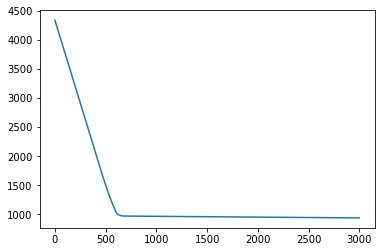

In [184]:
svm.run()

In [185]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


predict = svm.predict(X_test, test = True) # check performance
print('ROCAUC score:',roc_auc_score(y_test, predict))
print('Accuracy score:',accuracy_score(y_test, predict))
print('F1 score:',f1_score(y_test, predict, pos_label=1))

ROCAUC score: 0.6560598261267445
Accuracy score: 0.6549344375431332
F1 score: 0.6630727762803235


In [192]:
# Comparing it with Sklearn SVC

from sklearn.svm import SVC

model = SVC()
model.fit(X_train, y_train)

SVC()

In [193]:
predict = model.predict(X_test) # check performance
print('ROCAUC score:',roc_auc_score(y_test, predict))
print('Accuracy score:',accuracy_score(y_test, predict))
print('F1 score:',f1_score(y_test, predict, pos_label=1))

ROCAUC score: 0.6500285975749256
Accuracy score: 0.6528640441683919
F1 score: 0.6042486231313926


As we can see, our model performs better than Sklearn's Support Vector Classifier

In [194]:
svm.W

array([-3.12238777e-01,  3.39181375e-01, -1.55863748e-01, -5.01640900e-01,
       -6.54928187e-04, -1.76406241e+00, -1.09541804e+00, -1.08730028e+00,
       -3.05079072e-01, -4.73615362e-01, -2.00537398e-01,  3.55085106e-01,
        6.89309976e-01,  4.10466473e-01, -5.64808969e-01,  5.99210900e-01,
       -1.62887432e-01,  1.53622559e+00])